# Jupyter notebook based on ImageD11 to process 3DXRD data
# Written by Haixing Fang, Jon Wright and James Ball
## Date: 13/02/2024

Now we have good experimental parameters, we can index more grains!

For this example I have chosen a deformed dataset.

In [1]:
# There is a bug with the current version of ImageD11 in the site-wide Jupyter env.
# This has been fixed here: https://github.com/FABLE-3DXRD/ImageD11/commit/4af88b886b1775585e868f2339a0eb975401468f
# Until a new release has been made and added to the env, we need to get the latest version of ImageD11 from GitHub
# Put it in your home directory
# USER: Change the path below to point to your local copy of ImageD11:

import os

username = os.environ.get("USER")

id11_code_path = f"/home/esrf/{username}/Code/ImageD11"

import sys

sys.path.insert(0, id11_code_path)

In [2]:
# import functions we need

import os, glob, pprint
import numpy as np
import h5py
from tqdm.notebook import tqdm

import matplotlib
%matplotlib widget
from matplotlib import pyplot as plt

import utils

import ImageD11.grain
import ImageD11.indexing
import ImageD11.columnfile
from ImageD11.sinograms import properties, dataset

from ImageD11.blobcorrector import eiger_spatial

In [3]:
# NEW DATASETS

### USER: specify your experimental directory

base_dir = "/data/visitor/ma5837/id11/20240208"

rawdata_path = os.path.join(base_dir, 'RAW_DATA')

!ls -lrt {rawdata_path}

processed_data_root_dir = os.path.join(base_dir, 'PROCESSED_DATA')  # USER: modify this to change the destination folder if desired

total 2941
drwxr-x---  3 opid11 id11    4096 Feb  7 13:36 nanox_test
drwxr-x---  3 opid11 id11    4096 Feb  7 17:05 nanox_test_02_HC
drwxr-x---  3 opid11 id11    4096 Feb  7 17:34 nanox_test_no_sample
drwxr-x---  3 opid11 id11    4096 Feb  8 08:25 sample
drwxr-x---  3 opid11 id11    4096 Feb  8 08:26 test_stress_session
drwxr-x---  3 opid11 id11    4096 Feb  8 09:26 S06
drwxr-x--- 16 opid11 id11    4096 Feb  8 14:57 S20
drwxr-x---  3 opid11 id11    4096 Feb  8 16:26 S11
drwxr-x---  3 opid11 id11    4096 Feb  8 17:17 S05
drwxr-x--- 20 opid11 id11    4096 Feb  8 21:18 S20_HC1
drwxr-x--- 13 opid11 id11    4096 Feb  9 08:38 S18
drwxr-x---  3 opid11 id11    4096 Feb  9 10:14 empty_no_sample
drwxr-x--- 12 opid11 id11    4096 Feb  9 10:54 S17
drwxr-x--- 12 opid11 id11    4096 Feb  9 12:34 S16
drwxr-x---  2 opid11 id11    4096 Feb  9 13:59 test_fatigue_curvesave
drwxr-x---  2 opid11 id11    4096 Feb  9 14:11 S18_HC_fatigue_plots
drwxr-x---  2 opid11 id11    4096 Feb  9 14:47 S17_fatigue_plots


In [4]:
# USER: pick a sample and a dataset you want to segment

sample = "S12"
dataset = "FF_zeries_0"

In [5]:
# desination of H5 files

dset_path = os.path.join(processed_data_root_dir, sample, f"{sample}_{dataset}", f"{sample}_{dataset}_dataset.h5")

# USER: specify the path to the parameter file

parfile = 'Fe_refined.par'

In [6]:
# load the dataset from file

ds = ImageD11.sinograms.dataset.load(dset_path)

print(ds)
print(ds.shape)

dataroot = "/data/visitor/ma5837/id11/20240208/RAW_DATA"
analysisroot = "/data/visitor/ma5837/id11/20240208/PROCESSED_DATA"
sample = "S12"
dset = "FF_zeries_0"
shape = ( 1, 1440)
# scans 1 from 1.1 to 1.1
(1, 1440)


In [7]:
# load 3d columnfile from disk

cf_3d = ImageD11.columnfile.colfile_from_hdf(ds.col3dfile)

cf_3d.parameters.loadparameters(parfile)
cf_3d.updateGeometry()

if "index" not in cf_3d.titles:
    cf_3d.addcolumn(np.arange(cf_3d.nrows), "index")

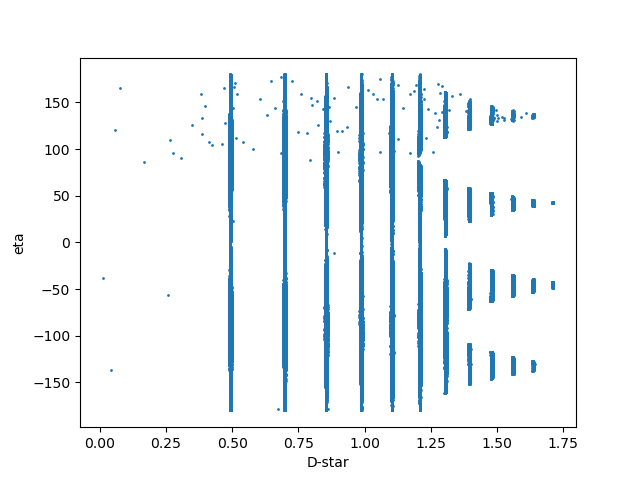

In [8]:
# plot the 3D peaks (fewer of them) as a cake (two-theta vs eta)
# if the parameters in the par file are good, these should look like straight lines

fig, ax = plt.subplots()

ax.scatter(cf_3d.ds, cf_3d.eta, s=1)

ax.set_xlabel("D-star")
ax.set_ylabel("eta")

plt.show()

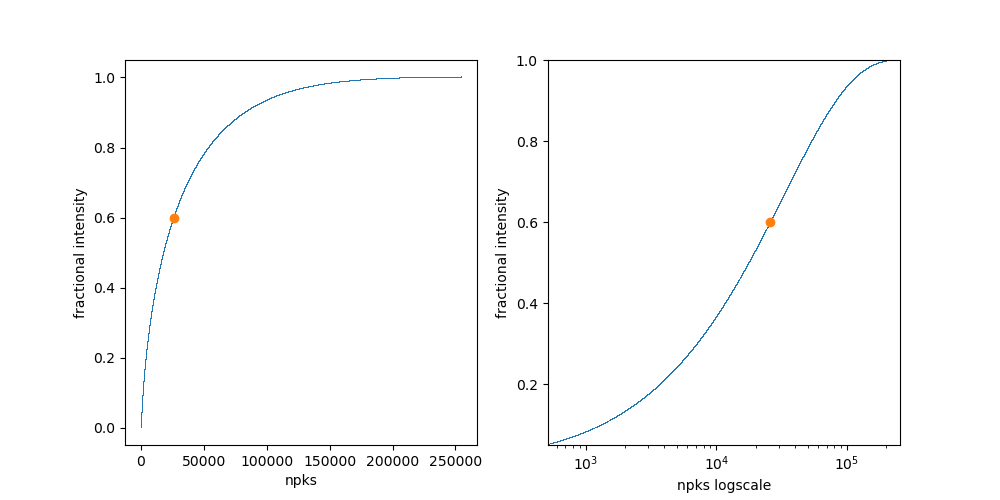

Got 25883 strong peaks for indexing


In [9]:
# here we are filtering our peaks (cf_2d) to select only the strongest ones for indexing purposes only!
# dsmax is being set to limit rings given to the indexer
# because we have so many 3d peaks, we will filter down to 3 rings

# USER: modify the "frac" parameter below and re-run the cell until we have around 25,000 peaks for indexing

cf_strong = utils.selectpeaks(cf_3d, frac=0.6, dsmax=0.92, doplot=0.05, dstol=0.01)
print(f"Got {cf_strong.nrows} strong peaks for indexing")
cf_strong.writefile(f'{sample}_{dataset}_3d_peaks_strong.flt')

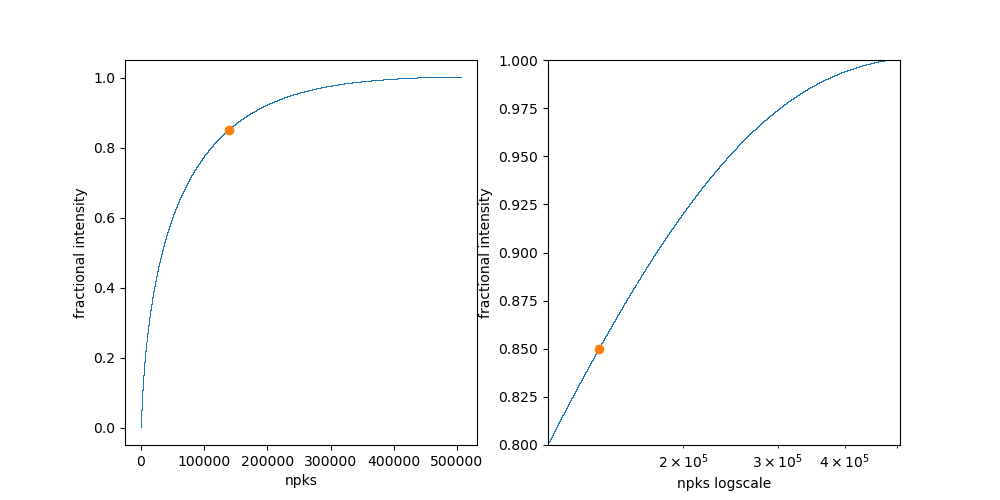

Got 139386 strong peaks for makemap


In [10]:
# we will also export some additional strong peaks across all rings
# this will be useful for grain refinement later (using makemap)

cf_strong_allrings = utils.selectpeaks(cf_3d, frac=0.85, dsmax=cf_3d.ds.max(), doplot=0.8, dstol=0.01)
print(f"Got {cf_strong_allrings.nrows} strong peaks for makemap")
cf_strong_allrings_path = f'{sample}_{dataset}_3d_peaks_strong_all_rings.flt'
cf_strong_allrings.writefile(cf_strong_allrings_path)

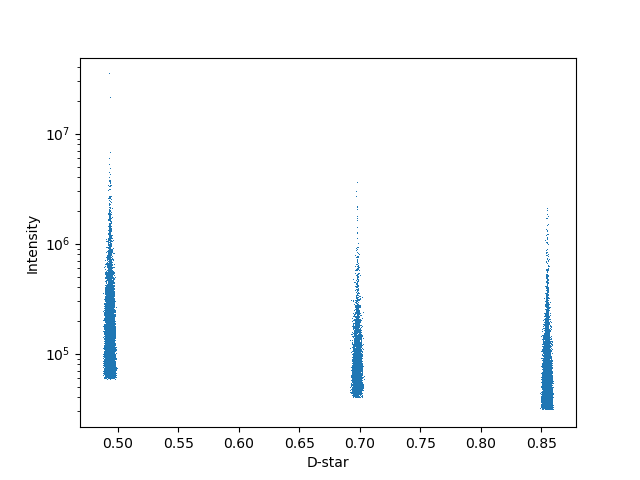

In [11]:
# now we can take a look at the intensities of the remaining peaks

fig, ax = plt.subplots()

ax.plot(cf_strong.ds, cf_strong.sum_intensity,',')
ax.semilogy()

ax.set_xlabel("D-star")
ax.set_ylabel("Intensity")

plt.show()

In [12]:
# now we can define a unit cell from our parameters

Fe = ImageD11.unitcell.unitcell_from_parameters(cf_strong.parameters)
Fe.makerings(cf_strong.ds.max())

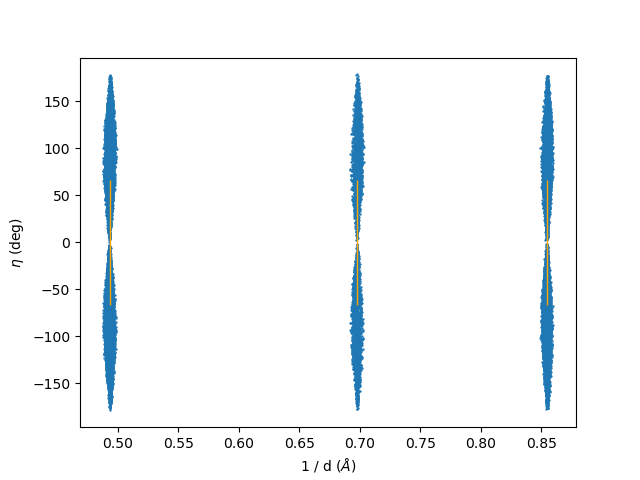

In [13]:
# now let's plot our peaks again, with the rings from the unitcell included, to check our lattice parameters are good

fig, ax = plt.subplots()

skip=1
ax.scatter( cf_strong.ds[::skip], cf_strong.eta[::skip], s=0.5)
ax.plot( Fe.ringds, [0,]*len(Fe.ringds), '|', ms=90, c='orange')
ax.set_xlabel('1 / d ($\AA$)')
ax.set_ylabel('$\\eta$ (deg)')

plt.show()

In [14]:
# specify our ImageD11 indexer with these peaks

indexer = ImageD11.indexing.indexer_from_colfile(cf_strong)

print(f"Indexing {cf_strong.nrows} peaks")

# USER: set a tolerance in d-space (for assigning peaks to powder rings)

indexer.ds_tol = 0.05

# change the log level so we can see what the ring assigments look like

ImageD11.indexing.loglevel = 1

# assign peaks to powder rings

indexer.assigntorings()

# change log level back again

ImageD11.indexing.loglevel = 3

info: gv: [[-0.05803119  0.06059429 -0.85093097]
 [-0.06684008  0.12471161 -0.84203551]
 [-0.06000537  0.18710853 -0.83178757]
 ...
 [-0.0119678   0.83915096 -0.15173352]
 [-0.1177152  -0.81752145 -0.21379654]
 [ 0.00090641  0.47016601  0.14144431]] (25883, 3) float64
Indexing 25883 peaks
info: Assign to rings, maximum d-spacing considered: 0.859919
info: Ring assignment array shape (25883,)
info: Ring     (  h,  k,  l) Mult  total indexed to_index  ubis  peaks_per_ubi   tth
info: Ring 2   ( -2, -1, -1)   24   9400       0     9400   N/A     N/A  9.30
info: Ring 1   ( -2,  0,  0)    6   3692       0     3692   N/A     N/A  7.59
info: Ring 0   ( -1, -1,  0)   12  12791       0    12791   N/A     N/A  5.36
info: Using only those peaks which are assigned to rings for scoring trial matrices
info: Shape of scoring matrix (25883, 3)


In [15]:
%%time

# we want to index low multiplicity rings
# choose max_multiplicity such that we get 2-3 low-multiplicity rings
# in this case, we will find orientations on 2 rings (faster for many peaks) and include the third ring for minpeaks calculations

max_multiplicity = 13

min_counts_on_ring = 0

n_peaks_expected = 0
rings = []
for i, dstar in enumerate(indexer.unitcell.ringds):
    multiplicity = len(indexer.unitcell.ringhkls[indexer.unitcell.ringds[i]])
    counts_on_this_ring = (indexer.ra == i).sum()
    if counts_on_this_ring > min_counts_on_ring:
        n_peaks_expected += multiplicity
        if multiplicity < max_multiplicity:
            rings.append((counts_on_this_ring, multiplicity, i))
        
rings.sort()

print(f"{n_peaks_expected} peaks expected")
print(f"Trying these rings (counts, multiplicity, ring number): {rings}")

# USER: specify the HKL tolerances you want to use for indexing
hkl_tols_seq = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1]

# USER: specify the fraction of the total expected peaks
fracs = [0.9, 0.75]

# ImageD11.cImageD11.cimaged11_omp_set_num_threads(1)
ImageD11.indexing.loglevel=3

# indexer.uniqueness = 0.3
indexer.cosine_tol = np.cos(np.radians(90.25))

# iterate over HKL tolerances
for frac in fracs:
    for tol in hkl_tols_seq:
        indexer.minpks = n_peaks_expected*frac
        indexer.hkl_tol = tol
        
        # iterate over rings
        
        for i in range(len(rings)):
            for j in range(i, len(rings)):
                indexer.ring_1 = rings[i][2]
                indexer.ring_2 = rings[j][2]
    
                indexer.find()
                indexer.scorethem()                

        print(frac, tol, len(indexer.ubis))

42 peaks expected
Trying these rings (counts, multiplicity, ring number): [(3692, 6, 1), (12791, 12, 0)]
0.9 0.01 63
0.9 0.02 363
0.9 0.03 516
0.9 0.04 534
0.9 0.05 534
0.9 0.1 534
0.75 0.01 539
0.75 0.02 541
0.75 0.03 553
0.75 0.04 554
0.75 0.05 554
0.75 0.1 554
CPU times: user 12h 23min 3s, sys: 1h 26min 59s, total: 13h 50min 2s
Wall time: 22min 50s


In [16]:
# create grain objects
grains = [ImageD11.grain.grain(ubi, translation=np.array([0., 0., 0.])) for ubi in indexer.ubis]

# set grain GIDs (useful if we ever delete a grain)
for i, g in enumerate(grains):
    g.gid = i

In [17]:
# plot pole figures?

In [18]:
tmp_ubi_path = f'{sample}_{dataset}_grains.ubi'
tmp_map_path = f'{sample}_{dataset}_grains.map'

new_flt_path = f'{sample}_{dataset}_3d_peaks_strong_all_rings.flt.new'  # flt file containing assignments from makemap
unindexed_flt_path = f'{sample}_{dataset}_3d_peaks_strong_all_rings.flt.unindexed'  # remaining unassigned peaks from makemap

In [19]:
ImageD11.grain.write_grain_file(tmp_ubi_path, grains)

In [20]:
omegas_sorted = np.sort(ds.omega)[0]
omega_slop = np.round(np.diff(omegas_sorted).mean(), 3)

makemap_hkl_tol_seq = [0.05, 0.025, 0.01]

In [21]:
for inc, makemap_tol in enumerate(makemap_hkl_tol_seq):
    print(f"Running makemap {inc+1}/{len(makemap_hkl_tol_seq)}")
    if inc == 0:  # ubi into map
        makemap_output = !makemap.py -p {parfile} -u {tmp_ubi_path} -U {tmp_map_path} -f {cf_strong_allrings_path} -F {unindexed_flt_path} -s cubic -t {makemap_hkl_tol_seq[inc]} --omega_slop={omega_slop} --no_sort
    else:  # map into map
        makemap_output = !makemap.py -p {parfile} -u {tmp_map_path} -U {tmp_map_path} -f {cf_strong_allrings_path} -F {unindexed_flt_path} -s cubic -t {makemap_hkl_tol_seq[inc]} --omega_slop={omega_slop} --no_sort

Running makemap 1/3
Running makemap 2/3
Running makemap 3/3


In [22]:
# re-import our refined grains from the makemap procedure

grains2 = ImageD11.grain.read_grain_file(tmp_map_path)

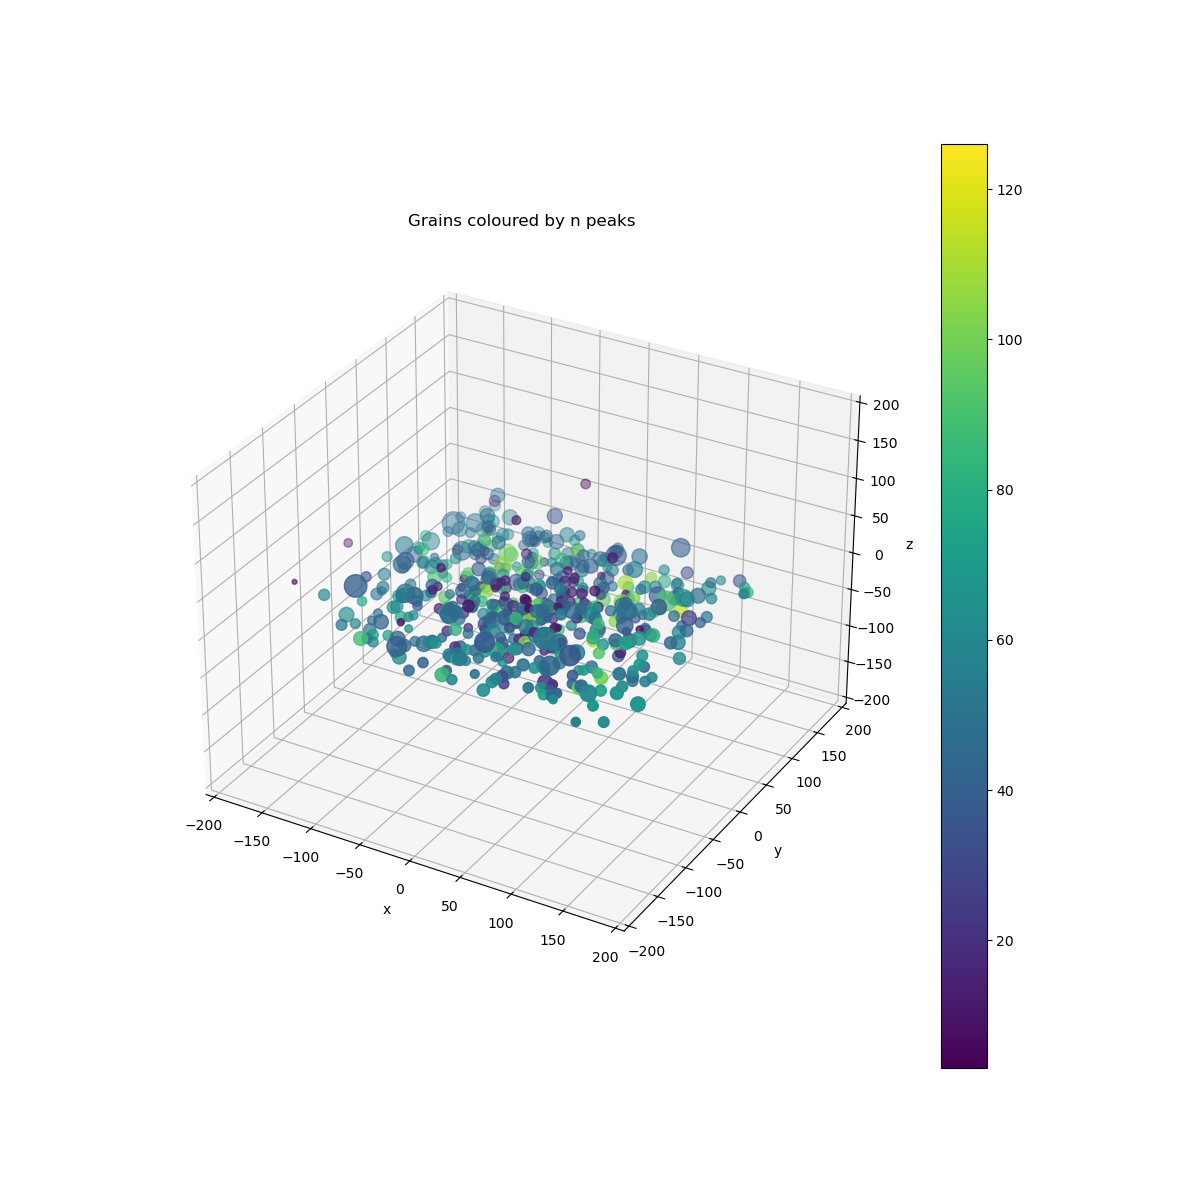

In [23]:
centre_plot = False

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
xx = [grain.translation[0] for grain in grains2]
yy = [grain.translation[1] for grain in grains2]
zz = [grain.translation[2] for grain in grains2]
# col = [utils.grain_to_rgb(grain) for grain in grains2]  # IPF-Z colour instead
col = [float(grain.npks) for grain in grains2]
sizes = [0.01*(float(grain.intensity_info.split("mean = ")[1].split(" , ")[0].replace("'", ""))) for grain in grains2]
if centre_plot:
    scatterplot = ax.scatter(xx-np.mean(xx), yy-np.mean(yy), zz, c=col, s=sizes)
else:
    scatterplot = ax.scatter(xx, yy, zz, c=col, s=sizes)
ax.set_xlim(-200,200)
ax.set_ylim(-200,200)
ax.set_zlim(-200,200)
plt.colorbar(scatterplot)
ax.set_title("Grains coloured by n peaks")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

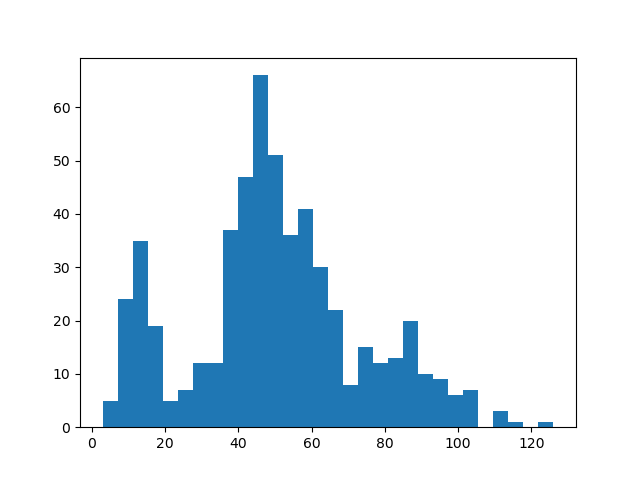

In [24]:
fig, ax = plt.subplots()
ax.hist([float(grain.npks) for grain in grains2], bins=30)
plt.show()

In [25]:
# find the spike
absolute_minpks = 30

In [26]:
# filter out grains with fewer than 15 peaks
grains_filtered = [grain for grain in grains2 if float(grain.npks) > absolute_minpks]

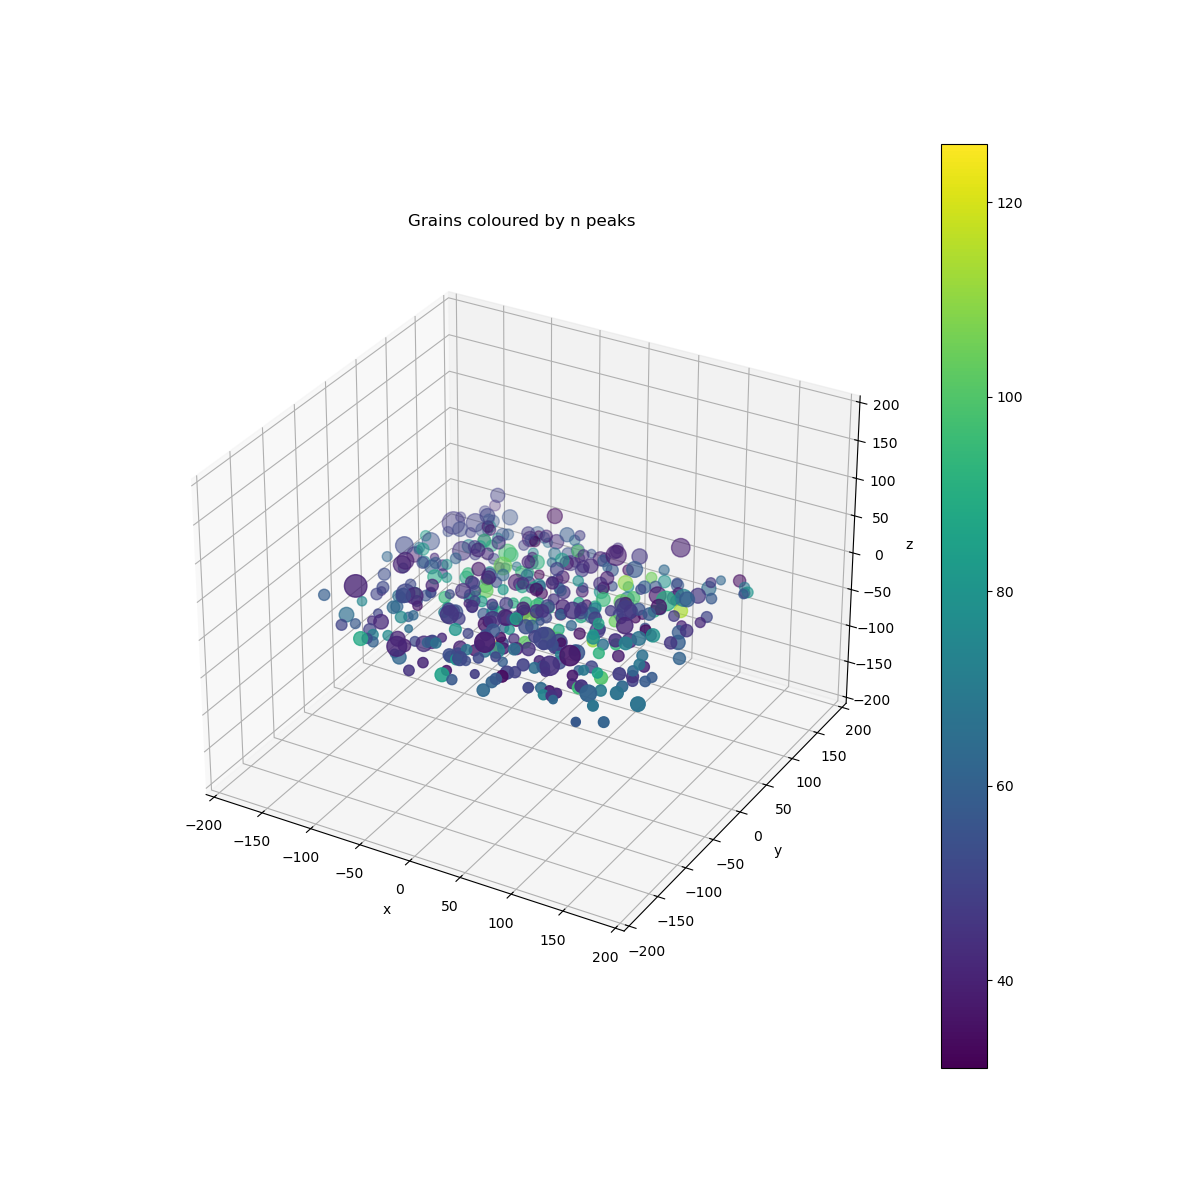

In [27]:
centre_plot = False

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
xx = [grain.translation[0] for grain in grains_filtered]
yy = [grain.translation[1] for grain in grains_filtered]
zz = [grain.translation[2] for grain in grains_filtered]
# col = [utils.grain_to_rgb(grain) for grain in grains_filtered]  # IPF-Z colour instead
col = [float(grain.npks) for grain in grains_filtered]
sizes = [0.01*(float(grain.intensity_info.split("mean = ")[1].split(" , ")[0].replace("'", ""))) for grain in grains_filtered]
if centre_plot:
    scatterplot = ax.scatter(xx-np.mean(xx), yy-np.mean(yy), zz, c=col, s=sizes)
else:
    scatterplot = ax.scatter(xx, yy, zz, c=col, s=sizes)
ax.set_xlim(-200,200)
ax.set_ylim(-200,200)
ax.set_zlim(-200,200)
plt.colorbar(scatterplot)
ax.set_title("Grains coloured by n peaks")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

In [28]:
for grain in grains_filtered:
    grain.gid = int(grain.name.split(":")[0])

In [29]:
# now we will assign our strong peaks across all rings to the grains
# so we can save the data to file for later

In [30]:
tol = 0.05

# column to store the grain labels
labels = np.zeros(cf_strong_allrings.nrows, 'i')
# get all g-vectors from columnfile
gv = np.transpose((cf_strong_allrings.gx, cf_strong_allrings.gy, cf_strong_allrings.gz)).astype(float)
# column to store drlv2 (error in hkl)
drlv2 =  np.ones(cf_strong_allrings.nrows, 'd')
# iterate over all grains
print(f"Scoring and assigning {len(grains_filtered)} grains")
for g in tqdm(grains_filtered):
    n = ImageD11.cImageD11.score_and_assign(g.ubi, gv, tol, drlv2, labels, g.gid)

# add the labels column to the columnfile
cf_strong_allrings.addcolumn(labels, 'grain_id')

print("Storing peak data in grains")
# iterate through all the grains
for g in tqdm(grains_filtered):
    # store this grain's peak indices so we know which 4D peaks we used for indexing
    g.peaks_3d = cf_strong_allrings.index[cf_strong_allrings.grain_id == g.gid]

Scoring and assigning 452 grains


  0%|          | 0/452 [00:00<?, ?it/s]

Storing peak data in grains


  0%|          | 0/452 [00:00<?, ?it/s]

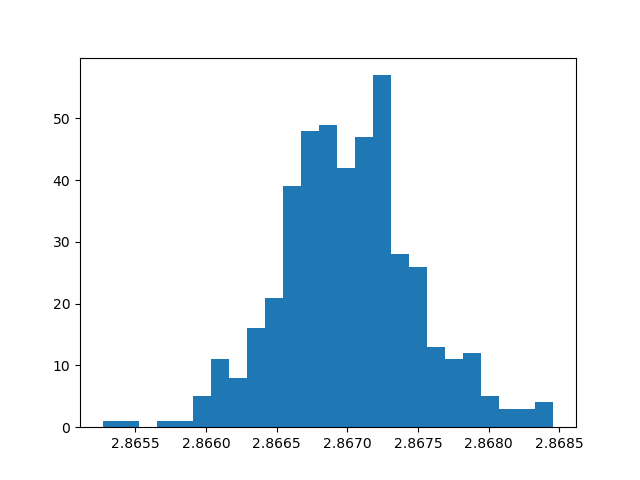

2.8670101274662922


In [31]:
fig, ax = plt.subplots()
ax.hist([np.mean(grain.unitcell[0:3]) for grain in grains_filtered], bins=25)
plt.show()

print(np.mean([np.mean(grain.unitcell[0:3]) for grain in grains_filtered]))

In [8]:
cmp = {'compression':'gzip',
       'compression_opts': 2,
       'shuffle' : True }

def save_array(grp, name, ary):
    hds = grp.require_dataset(name, 
                              shape=ary.shape,
                              dtype=ary.dtype,
                              **cmp)
    hds[:] = ary
    return hds

def save_grains(grains, ds):
    with h5py.File(ds.grainsfile, 'w') as hout:
        grn = hout.create_group('grains')
        for g in tqdm(grains):
            gg = grn.create_group(str(g.gid))
            save_array(gg, 'peaks_3d_indexing', g.peaks_3d).attrs['description'] = "Strong 3D peaks that were assigned to this grain during indexing"
            gg.attrs.update({'ubi':g.ubi,
                            'translation':g.translation})

In [ ]:
# save grain data

save_grains(grains_filtered, ds)

In [ ]:
# Now that we're happy with our indexing parameters, we can define our indexing function to run for the rest of our data
# just modify the parameters at the start of the cell below according to what you found worked well above
# then run the two cells below

In [9]:
def index_dataset(ds):
    cf_strong_frac = 0.6
    cf_strong_dsmax = 0.92
    cf_strong_dstol = 0.01
    
    cf_strong_allrings_frac = 0.85
    cf_strong_allrings_dstol = 0.01
    
    indexer_dstol = 0.05
    indexer_max_mult = 13
    indexer_hkl_tols = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1]
    indexer_fracs = [0.9, 0.75]
    indexer_cosine_tol = np.cos(np.radians(90.25))
    indexer_max_grains = 1000
    
    makemap_min_ring_counts = 0
    makemap_hkl_tol_seq = [0.05, 0.025, 0.01]
    makemap_import_minpks = 30
    
    peak_assignment_hkl_tol = 0.05
    
    
    print("Loading 3D peaks")
    cf_3d = ImageD11.columnfile.colfile_from_hdf(ds.col3dfile)
    cf_3d.parameters.loadparameters(parfile)
    cf_3d.updateGeometry()
    if "index" not in cf_3d.titles:
        cf_3d.addcolumn(np.arange(cf_3d.nrows), "index")

    print("Filtering 3D peaks")
    cf_strong = utils.selectpeaks(cf_3d, frac=cf_strong_frac, dsmax=cf_strong_dsmax, doplot=None, dstol=cf_strong_dstol)
    print(f"Got {cf_strong.nrows} strong peaks for indexing")
    cf_strong_path = f'{sample}_{dataset}_3d_peaks_strong.flt'
    cf_strong.writefile(cf_strong_path)

    cf_strong_allrings = utils.selectpeaks(cf_3d, frac=cf_strong_allrings_frac, dsmax=cf_3d.ds.max(), doplot=None, dstol=cf_strong_allrings_dstol)
    print(f"Got {cf_strong_allrings.nrows} strong peaks for makemap")
    cf_strong_allrings_path = f'{sample}_{dataset}_3d_peaks_strong_all_rings.flt'
    cf_strong_allrings.writefile(cf_strong_allrings_path)

    print(f"Indexing {cf_strong.nrows} peaks")
    Fe = ImageD11.unitcell.unitcell_from_parameters(cf_strong.parameters)
    Fe.makerings(cf_strong.ds.max())
    indexer = ImageD11.indexing.indexer_from_colfile(cf_strong)

    ImageD11.indexing.loglevel = 3
    
    indexer.ds_tol = indexer_dstol
    indexer.assigntorings()
    indexer.max_grains = indexer_max_grains

    max_multiplicity = indexer_max_mult
    min_counts_on_ring = makemap_min_ring_counts

    n_peaks_expected = 0
    rings = []
    for i, dstar in enumerate(indexer.unitcell.ringds):
        multiplicity = len(indexer.unitcell.ringhkls[indexer.unitcell.ringds[i]])
        counts_on_this_ring = (indexer.ra == i).sum()
        if counts_on_this_ring > min_counts_on_ring:
            n_peaks_expected += multiplicity
            if multiplicity < max_multiplicity:
                rings.append((counts_on_this_ring, multiplicity, i))

    rings.sort()

    print(f"{n_peaks_expected} peaks expected")
    print(f"Trying these rings (counts, multiplicity, ring number): {rings}")
    hkl_tols_seq = indexer_hkl_tols
    fracs = indexer_fracs
    indexer.cosine_tol = indexer_cosine_tol

    for frac in fracs:
        for tol in hkl_tols_seq:
            indexer.minpks = n_peaks_expected*frac
            indexer.hkl_tol = tol
            for i in range(len(rings)):
                for j in range(i, len(rings)):
                    indexer.ring_1 = rings[i][2]
                    indexer.ring_2 = rings[j][2]

                    indexer.find()
                    indexer.scorethem()


    grains = [ImageD11.grain.grain(ubi, translation=np.array([0., 0., 0.])) for ubi in indexer.ubis]
    print(f"Found {len(grains)} grains")

    for i, g in enumerate(grains):
        g.gid = i

    tmp_ubi_path = f'{sample}_{dataset}_grains.ubi'
    tmp_map_path = f'{sample}_{dataset}_grains.map'

    new_flt_path = f'{sample}_{dataset}_3d_peaks_strong_all_rings.flt.new'  # flt file containing assignments from makemap
    unindexed_flt_path = f'{sample}_{dataset}_3d_peaks_strong_all_rings.flt.unindexed'  # remaining unassigned peaks from makemap

    ImageD11.grain.write_grain_file(tmp_ubi_path, grains)

    omegas_sorted = np.sort(ds.omega)[0]
    omega_slop = np.round(np.diff(omegas_sorted).mean(), 3)

    makemap_hkl_tol_seq = makemap_hkl_tol_seq

    for inc, makemap_tol in enumerate(makemap_hkl_tol_seq):
        print(f"Running makemap {inc+1}/{len(makemap_hkl_tol_seq)}")
        if inc == 0:  # ubi into map
            makemap_output = !makemap.py -p {parfile} -u {tmp_ubi_path} -U {tmp_map_path} -f {cf_strong_allrings_path} -F {unindexed_flt_path} -s cubic -t {makemap_hkl_tol_seq[inc]} --omega_slop={omega_slop} --no_sort
        else:  # map into map
            makemap_output = !makemap.py -p {parfile} -u {tmp_map_path} -U {tmp_map_path} -f {cf_strong_allrings_path} -F {unindexed_flt_path} -s cubic -t {makemap_hkl_tol_seq[inc]} --omega_slop={omega_slop} --no_sort

    grains2 = ImageD11.grain.read_grain_file(tmp_map_path)
    absolute_minpks = makemap_import_minpks
    grains_filtered = [grain for grain in grains2 if float(grain.npks) > absolute_minpks]

    for grain in grains_filtered:
        grain.gid = int(grain.name.split(":")[0])

    tol = peak_assignment_hkl_tol

    labels = np.zeros(cf_strong_allrings.nrows, 'i')
    gv = np.transpose((cf_strong_allrings.gx, cf_strong_allrings.gy, cf_strong_allrings.gz)).astype(float)
    drlv2 =  np.ones(cf_strong_allrings.nrows, 'd')
    print(f"Scoring and assigning {len(grains_filtered)} grains")
    for g in tqdm(grains_filtered):
        n = ImageD11.cImageD11.score_and_assign(g.ubi, gv, tol, drlv2, labels, g.gid)

    cf_strong_allrings.addcolumn(labels, 'grain_id')

    print("Storing peak data in grains")
    for g in tqdm(grains_filtered):
        g.peaks_3d = cf_strong_allrings.index[cf_strong_allrings.grain_id == g.gid]
    
    print("Saving grains")
    save_grains(grains_filtered, ds)
    
    if os.path.exists(cf_strong_path):
        os.remove(cf_strong_path)
        
    if os.path.exists(cf_strong_allrings_path):
        os.remove(cf_strong_allrings_path)
    
    if os.path.exists(tmp_ubi_path):
        os.remove(tmp_ubi_path)
        
    if os.path.exists(tmp_map_path):
        os.remove(tmp_map_path)
        
    if os.path.exists(new_flt_path):
        os.remove(new_flt_path)
        
    if os.path.exists(unindexed_flt_path):
        os.remove(unindexed_flt_path)

In [ ]:
# Now that we're happy with our indexing parameters, we can run the below cell to do this in bulk for many samples/datasets
# just modify samples_dict accordingly!

parfile = 'Fe_refined.par'

samples_dict = {
    "S13" : [
        "FF_zeries_0",
        "FF_zeries_1",
        "FF_zeries_2",
        "FF_zeries_3",
        "FF_zeries_4",
    ],
    "S14" : [
        "FF_zeries_0",
        "FF_zeries_1",
        "FF_zeries_2",
        "FF_zeries_3",
        "FF_zeries_4",
    ],
}

for sample, datasets in samples_dict.items():
    for dataset in datasets:
        print(f"Processing dataset {dataset} in sample {sample}")
        print("Importing DataSet object")
        dset_path = os.path.join(processed_data_root_dir, sample, f"{sample}_{dataset}", f"{sample}_{dataset}_dataset.h5")
        ds = ImageD11.sinograms.dataset.load(dset_path)
        print(f"I have a DataSet {ds.dset} in sample {ds.sample}")
        
        index_dataset(ds)

Processing dataset FF_zeries_0 in sample S13
Importing DataSet object
I have a DataSet FF_zeries_0 in sample S13
Loading 3D peaks
Filtering 3D peaks
Got 31609 strong peaks for indexing
Got 149447 strong peaks for makemap
Indexing 31609 peaks
42 peaks expected
Trying these rings (counts, multiplicity, ring number): [(4138, 6, 1), (16031, 12, 0)]
Found 703 grains
Running makemap 1/3
Running makemap 2/3
Running makemap 3/3
Scoring and assigning 533 grains


  0%|          | 0/533 [00:00<?, ?it/s]

Storing peak data in grains


  0%|          | 0/533 [00:00<?, ?it/s]

Saving grains


  0%|          | 0/533 [00:00<?, ?it/s]

Processing dataset FF_zeries_1 in sample S13
Importing DataSet object
I have a DataSet FF_zeries_1 in sample S13
Loading 3D peaks
Filtering 3D peaks
Got 31118 strong peaks for indexing
Got 148647 strong peaks for makemap
Indexing 31118 peaks
42 peaks expected
Trying these rings (counts, multiplicity, ring number): [(4010, 6, 1), (15921, 12, 0)]
Found 701 grains
Running makemap 1/3
Running makemap 2/3
Running makemap 3/3
Scoring and assigning 552 grains


  0%|          | 0/552 [00:00<?, ?it/s]

Storing peak data in grains


  0%|          | 0/552 [00:00<?, ?it/s]

Saving grains


  0%|          | 0/552 [00:00<?, ?it/s]

Processing dataset FF_zeries_2 in sample S13
Importing DataSet object
I have a DataSet FF_zeries_2 in sample S13
Loading 3D peaks
Filtering 3D peaks
Got 32605 strong peaks for indexing
Got 158846 strong peaks for makemap
Indexing 32605 peaks
42 peaks expected
Trying these rings (counts, multiplicity, ring number): [(4268, 6, 1), (16390, 12, 0)]
